In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.DataFrame(pd.read_csv("./World Energy Overview.csv"))
df = df.dropna()
df.head()

,Date,Total Fossil Fuels Production,Nuclear Electric Power Production,Total Renewable Energy Production,Total Primary Energy Production,Primary Energy Imports,Primary Energy Exports,Primary Energy Net Imports,Primary Energy Stock Change and Other,Total Fossil Fuels Consumption,Nuclear Electric Power Consumption,Total Renewable Energy Consumption,Total Primary Energy Consumption
0,1973-01-31,4.932632,0.068103,0.403981,5.404715,1.173080,0.125781,1.047299,0.771858,6.747651,0.068103,0.403981,7.223873
1,1973-02-28,4.729582,0.064634,0.360900,5.155115,1.168005,0.120883,1.047122,0.390129,6.163095,0.064634,0.360900,6.592366
2,1973-03-31,4.946902,0.072494,0.400161,5.419556,1.309473,0.139950,1.169523,-0.067640,6.044647,0.072494,0.400161,6.521439
3,1973-04-30,4.716271,0.064070,0.380470,5.160812,1.085169,0.194185,0.890984,-0.110067,5.493184,0.064070,0.380470,5.941729
4,1973-05-31,4.956995,0.062111,0.392141,5.411246,1.162804,0.196775,0.966029,-0.305335,5.613551,0.062111,0.392141,6.071940


In [9]:
# Xác định các biến thành phần độc lập và biến giải thích
compositional_cols = ['Total Fossil Fuels Production','Nuclear Electric Power Production','Total Renewable Energy Production']
compositional_cols_consumption = ['Total Fossil Fuels Consumption','Nuclear Electric Power Consumption','Total Renewable Energy Consumption']

#data = 
var_target = df['Total Primary Energy Consumption']
#family = family[(family != 0).all(axis=1)]

# chuyển dữ liệu thành phần
compositional_data = df[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()


,Total Fossil Fuels Production,Nuclear Electric Power Production,Total Renewable Energy Production
0,0.912653,0.012601,0.074746
1,0.917454,0.012538,0.070008
2,0.912787,0.013376,0.073836
3,0.913862,0.012415,0.073723
4,0.916054,0.011478,0.072468


In [10]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = ilr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
#clr_compositional_data = pd.DataFrame(clr_compositional_data, columns=compositional_cols)
clr_compositional_data = pd.DataFrame(clr_compositional_data)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(compositional_data, var_target, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                           Robust linear Model Regression Results                           
Dep. Variable:     Total Primary Energy Consumption   No. Observations:                  479
Model:                                          RLM   Df Residuals:                      476
Method:                                        IRLS   Df Model:                            2
Norm:                                        HuberT                                         
Scale Est.:                                     mad                                         
Cov Type:                                        H1                                         
Date:                              Wed, 22 May 2024                                         
Time:                                      15:35:27                                         
No. Iterations:                                  31                                         
                 coef    std err          z      P>|z|      [0.025    

In [11]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 0.6183400559653656


In [12]:
# Độ lệch chuẩn của Total.Household.Income
std_income = np.std(y_test)
print(f"Standard Deviation of Total Household Income: {std_income}")

Standard Deviation of Total Household Income: 0.9179016711039846


/tmp/ipykernel_37408/12606955.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')


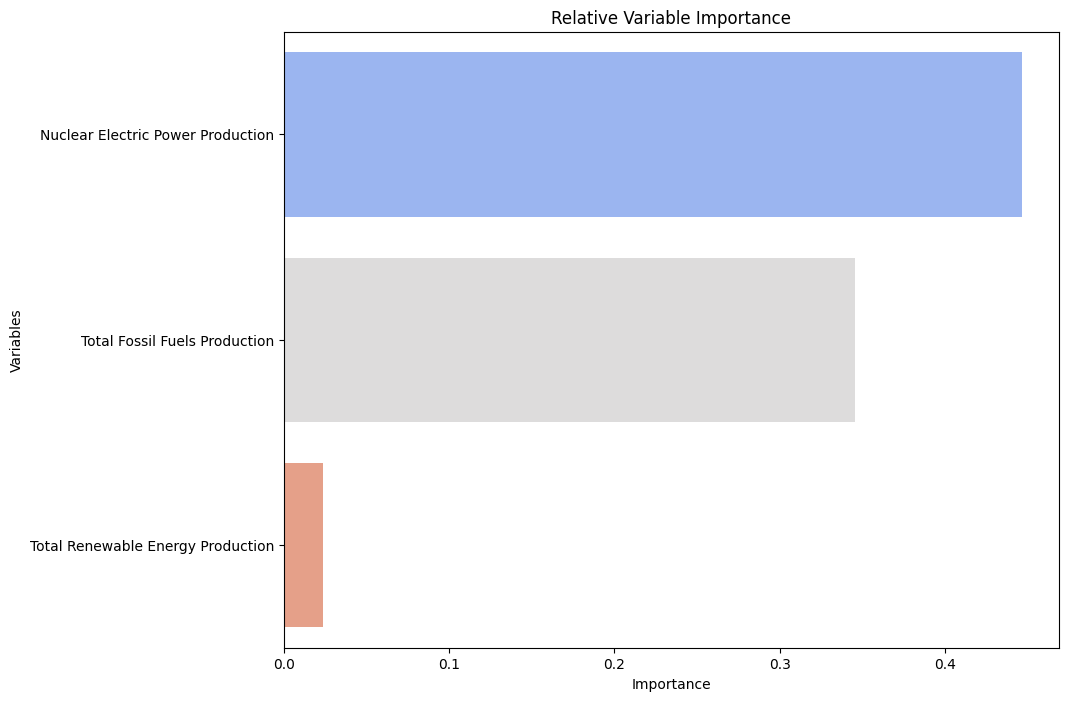

In [13]:
# Vẽ biểu đồ tầm quan trọng của biến
importance = rlm_results.params[1:]
variables = X_train.columns

importance_df = pd.DataFrame({
    'Variables': variables,
    'Importance': np.abs(importance)
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Variables', palette='coolwarm')
plt.title('Relative Variable Importance')
plt.show()


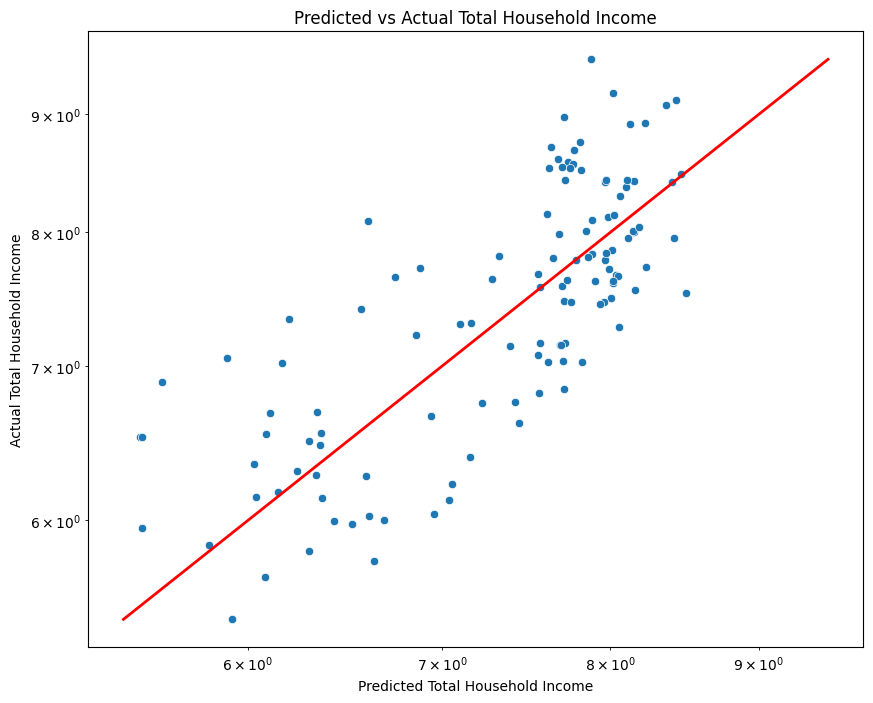

In [14]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted Total Household Income')
plt.ylabel('Actual Total Household Income')
plt.title('Predicted vs Actual Total Household Income')
plt.show()